# Hotel Customer Segmentation - Clustering and Pre-processing

## Objective
### Prepairing data for clustering and classification predictions. 

### Modeling for business KPIs identified:
1. Increased bookings and subsequently revenues.
2. Reduced cancelations and noshows

* By targeting hotel accomodations, offerings and makerting, you can trigger more impactful communications and promotions. There should be a positive impact in bookings and revenue. This can be enhanced with better customer segmenation, user personas and user case stories.
* By labeling a customer record in the booking system based on value, management is better able to make decisions about resources and priorites.
* By predicting if a customer is at risk of attrition, commnications and promotion triggers as well as managment action could potential reduce the rate of both. 

## Data

A clean dataframe including normalized RFM calculation from
a real-world customer dataset with 31 variables describes
83,590 instances (customers) from a hotel in Lisbon, Portugal.
Instances include; customer personal, behavioral,
demographic, and geographical information for 3 full years.
The dataset can be found on Kaggle [here].(https://www.kaggle.com/datasets/nantonio/a-hotels-customers-dataset)

Kaggle dataset origin, domain assumptions and data collection information: 

Nuno Antonio, Ana de Almeida, Luis Nunes. A hotel's customer's personal, behavioral, demographic, and geographic dataset from Lisbon, Portugal (2015-2018). Data in Brief 33(2020)106583, 24(November), 2020. URL: https://www.sciencedirect.com/journal/data-in-brief.

## Data Assumptions

Data is aggreated and querried from company SQL database and provided in the flatfile.
* Some hotels have a policy of creating a profile for each guest companion(adult or children) only in particular cases and with authorization at times. 
* Typically a customer profile is created by one of three things:
    - customer's first checked-out at the hotel
    - customer's first cancelation
    - customer's first no-show
* Sometimes there are more than one profile for the same customer
* Only after the customer's first stay can hotels confirm the guest's personal details, such as nationality.

## Process

1. Feature engineering and transformation   
2. Data scaling
3. Data split for training and testing
4. Baseline model 

## Questions

1. Do categorical variables need to be encoded? 
2. Does the data need scaling? 
3. What is the optimal number of clusters? Elbow method?
4. Can we model a churn classification or a CLV regression with the same clustering dataset?
5. What baseline models will we use for attrition prediction?

## Considerations from EDA

1. Scaling and and log transformations were performed on the RFM data. 
2. Few pairwise correlations observed in heatmap. 
2. High embalence in the a value feature of Total Revenue. 
3. High embalence in categorical features related to sales and market segments. 

## Import Data

Import previous EDA notebook progress. 

In [136]:
from IPython.utils import io
with io.capture_output() as captured:
    %run 2_EDA.ipynb

In [137]:
hotel_customer_rfm.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   3         DEU  31.0               1095                0             0.0   
3   4         FRA  60.0               1095               93           240.0   
4   5         FRA  51.0               1095                0             0.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2           0.0                 0                 0                  0  ...   
3          60.0                 0                 0                  1  ...   
4           0.0                 0                 0                  0  ...   

   SRTwinBed  SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  \
0          0               0                   0                     0   
1          0               0                   0                     0   
2          0               0                   0                     0   
3          0               0                   0                     0   
4          0               0                   0                     0   

  SRQuietRoom Country  TotalRevenue  Recency  Frequency  Monetary  
0           0     PRT         476.3      151          5     476.3  
1           0     PRT         333.0     1100          5     333.0  
2           0     DEU           0.0       -1          0       0.0  
3           0     FRA         300.0     1100          5     300.0  
4           0     FRA           0.0       -1          0       0.0  

[5 rows x 34 columns]

## Import New Libraries

In [138]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Feature Engineering

How many RFM cusotomer categories serve our business uses and KPIs?

Here are some important segments to understand and viusalize for our goals:
1. High, medium and low value
2. At rist of churn
3. Likely to re-book
 *  What are the behaviors and demographics of these segments?

### RFM Scoring - Overall Cusotmer Value Based on Recencey, Frequency and Monetary Spend

#### Low, Medium & High Value Customers. *Not based on lifetime value prediction. 

Let's first segment according to the customer RFM values by assigning an overal score column to the customer. First we will make a score for each Recency, Frequency and Monetary based on what quantiles the customer value sits in, within the distribution of scores.  We can label these categories for better interpretability as well. We can ues these RFM scores to compare to our clustering model later on. We are not using the normalized values of these categories, but do have that information ready in table hotel_customer_rfm_norm if we need to use it. I believe we can do this once we start clustering. 

#### Create label columns for customers of thier recency and frequency scores
##### Recency decreases because a lower value is better in this case.

In [139]:
r_labels = range(3,0,-1); f_labels = range(1,4)

r_groups = pd.qcut(hotel_customer_rfm['Recency'], q=3, labels=r_labels)

f_groups = pd.qcut(hotel_customer_rfm['Frequency'], q=3, labels=f_labels)

hotel_customer_rfm = hotel_customer_rfm.assign(R=r_groups.values, F=f_groups.values)

#### Create label columns for customers of their monetary scores

In [140]:
m_labels = range(1,4)

m_groups = pd.qcut(hotel_customer_rfm['Monetary'], q=3, labels=m_labels)

hotel_customer_rfm = hotel_customer_rfm.assign(M=m_groups.values)

#### Calculate RFM Score

In [141]:
hotel_customer_rfm['RFM_Score'] = hotel_customer_rfm[['R', 'F', 'M']].sum(axis=1)
print(hotel_customer_rfm['RFM_Score'].head())

0    8
1    6
2    5
3    6
4    5
Name: RFM_Score, dtype: int64


How many different scores are there?

In [142]:
hotel_customer_rfm.RFM_Score.nunique()

7

In [143]:
hotel_customer_rfm.RFM_Score.unique()

array([8, 6, 5, 7, 3, 4, 9], dtype=int64)

What is the average monetary value of each RFM score segment?

In [144]:
hotel_customer_rfm['Monetary'].groupby(hotel_customer_rfm['RFM_Score']).mean()

RFM_Score
3    103.526495
4    145.801781
5    101.182220
6    391.573943
7    639.699417
8    836.732771
9    942.547272
Name: Monetary, dtype: float64

What is the distribution of RFM scores in our data?

<AxesSubplot:>

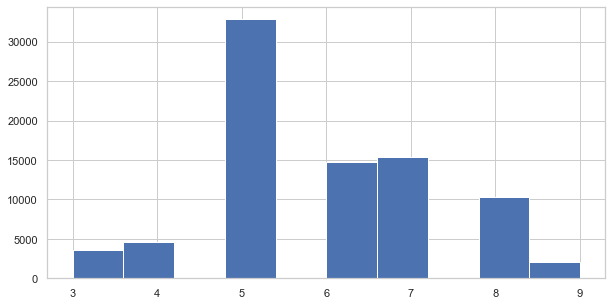

In [145]:
hotel_customer_rfm.RFM_Score.hist()

### Identifying RFM Segments

Build segmentation based on RFM Scores and assing it to each cusomer. Our top earning score is 9. If we evenly divide the levels, into Low, Medium and High is should be 1-3 Low, 4-6 Medium & 7-10 Top respectively:

* 0 - 3: Low Value
* 4 - 6: Mid Value
* 7 - 10: Top Value 

In [146]:
#Segment level function

def rfm_level(hotel_customer_rfm):
    if hotel_customer_rfm['RFM_Score'] >= 7:
        return 'Top'
    elif ((hotel_customer_rfm['RFM_Score'] >= 4) and (hotel_customer_rfm['RFM_Score'] < 7)):
        return 'Middle'
    else:
        return 'Low'

#Create RFM_Level feature for value segment label
hotel_customer_rfm['RFM_Segment'] = hotel_customer_rfm.apply(rfm_level, axis=1)


What are the average values for each RFM Segment level and the segment size?

In [147]:
RFM_Segment_agg = hotel_customer_rfm.groupby('RFM_Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)
print(RFM_Segment_agg)

            Recency Frequency Monetary       
               mean      mean     mean  count
RFM_Segment                                  
Low           839.1       1.0    103.5   3586
Middle        371.6       1.4    187.3  52162
Top           399.8       4.3    735.9  27842


In [148]:
fig1 = px.scatter(hotel_customer_rfm, x="Recency", y="Monetary", color="RFM_Segment",
                 size="Frequency")

fig1.update_layout(title="Customer Cluster Scatterplot")
fig1.show()

Coorelation heatmap with RFM features

<AxesSubplot:>

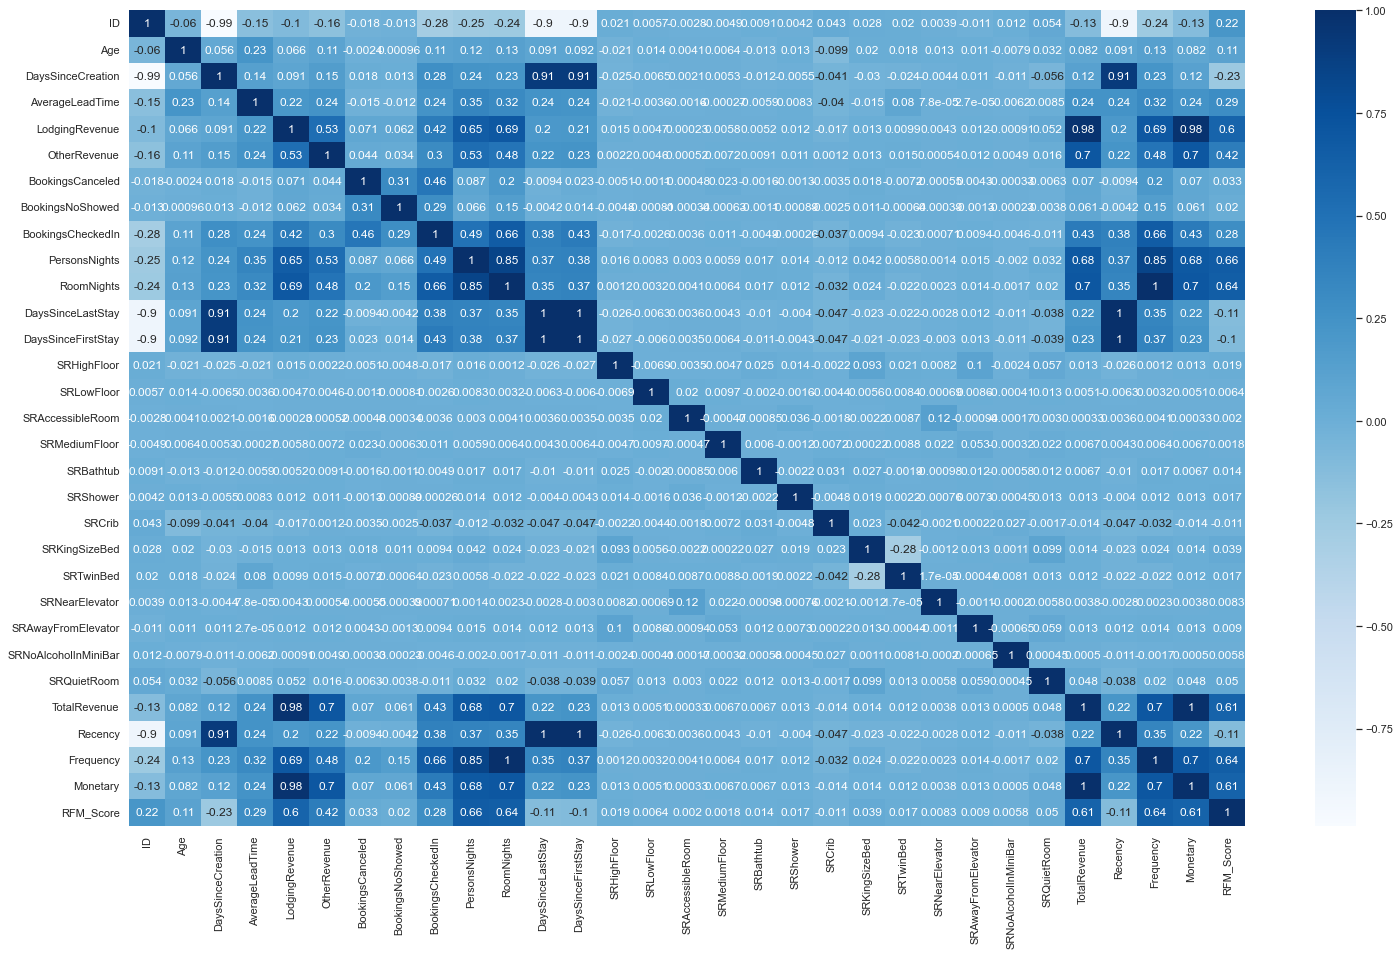

In [149]:
fig, ax = plt.subplots(figsize=(25, 15))

rfm_corr = hotel_customer_rfm.corr()
sns.heatmap(rfm_corr, cmap="Blues", annot= True,
        xticklabels=rfm_corr.columns,
        yticklabels=rfm_corr.columns)

In [150]:
hotel_customer_rfm.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   3         DEU  31.0               1095                0             0.0   
3   4         FRA  60.0               1095               93           240.0   
4   5         FRA  51.0               1095                0             0.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2           0.0                 0                 0                  0  ...   
3          60.0                 0                 0                  1  ...   
4           0.0                 0                 0                  0  ...   

   Country  TotalRevenue  Recency  Frequency Monetary  R  F  M  RFM_Score  \
0      PRT         476.3      151          5    476.3  2  3  3          8   
1      PRT         333.0     1100          5    333.0  1  3  2          6   
2      DEU           0.0       -1          0      0.0  3  1  1          5   
3      FRA         300.0     1100          5    300.0  1  3  2          6   
4      FRA           0.0       -1          0      0.0  3  1  1          5   

   RFM_Segment  
0          Top  
1       Middle  
2       Middle  
3       Middle  
4       Middle  

[5 rows x 39 columns]

### RFM Segmenting with  with KMeans Clustering

Use rfm_normalized dataframe which is scaled, in order to meet the data criteria for the KMeans algorithm.

dataframe with RFM quantile score segments

dataframe with RFM segments based on clusters - hotel_customer_rfm_cluster = 

In [205]:
hotel_customer_rfm_norm.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   3         DEU  31.0               1095                0             0.0   
3   4         FRA  60.0               1095               93           240.0   
4   5         FRA  51.0               1095                0             0.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2           0.0                 0                 0                  0  ...   
3          60.0                 0                 0                  1  ...   
4           0.0                 0                 0                  0  ...   

   SRTwinBed  SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  \
0          0               0                   0                     0   
1          0               0                   0                     0   
2          0               0                   0                     0   
3          0               0                   0                     0   
4          0               0                   0                     0   

  SRQuietRoom Country  TotalRevenue   Recency  Frequency  Monetary  
0           0     PRT         476.3 -0.720233   1.157658  0.247655  
1           0     PRT         333.0  2.013039   1.157658 -0.075240  
2           0     DEU           0.0 -1.158018  -1.033660 -0.825581  
3           0     FRA         300.0  2.013039   1.157658 -0.149598  
4           0     FRA           0.0 -1.158018  -1.033660 -0.825581  

[5 rows x 34 columns]

 Kmeans clustering is a fast and simple method of segmenting if the data meet have similar variable averages and standard deviations. The RFM variables we'll use to cluster have been normalized using the standard scaler in the previous EDA step. 

Data check for above criteria

In [206]:
# Get the key statistics of the dataset
print(hotel_customer_rfm_norm[['Recency', 'Frequency', 'Monetary']].describe())

            Recency     Frequency      Monetary
count  8.359000e+04  8.359000e+04  8.359000e+04
mean  -1.762939e-14  4.562220e-14  1.599711e-14
std    1.000006e+00  1.000006e+00  1.000006e+00
min   -1.158018e+00 -1.033660e+00 -8.255815e-01
25%   -1.080254e+00 -5.953967e-01 -6.610921e-01
50%   -1.009990e-01 -1.571331e-01 -1.801862e-01
75%    8.408135e-01  7.193940e-01  2.949739e-01
max    2.024559e+00  8.004510e+01  5.182227e+01


### Inital KMeans model with 3 clusters

In [207]:
Kmeans = KMeans(n_clusters=3, random_state=42, max_iter=50)

Kmeans.fit(rfm_normalized)

cluster_labels = Kmeans.labels_

#Create a dataframe with new cluster labels
rfm_kmeans3 = rfm.assign(RFM_Cluster=cluster_labels)

#Group data by cluster and calculate average RFM values and segment size per cluster
rfm_kmeans3_agg = rfm_kmeans3.groupby(['RFM_Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(rfm_kmeans3_agg)

            Recency Frequency Monetary       
               mean      mean     mean  count
RFM_Cluster                                  
0             340.8       2.5    398.1  27875
1             795.3       3.0    412.0  27933
2              65.2       1.6    288.7  27782


In [208]:
rfm_kmeans3.RFM_Cluster.nunique()

3

In [209]:
rfm_kmeans3.sort_values(by='RFM_Cluster')

ID  Recency  Frequency  Monetary  RFM_Cluster
41794  41795      399          2     182.0            0
37216  37217      466          3     536.0            0
37217  37218      465          2     245.0            0
37218  37219      465          2     325.5            0
37219  37220      464          1     325.0            0
...      ...      ...        ...       ...          ...
65062  65063       -1          0       0.0            2
65061  65062      164          4     987.4            2
65060  65061      161          1     199.0            2
65071  65072      167          7    1050.5            2
83589  83590       -1          0       0.0            2

[83590 rows x 5 columns]

In [210]:
rfm_kmeans3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83590 entries, 0 to 83589
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           83590 non-null  int64  
 1   Recency      83590 non-null  int64  
 2   Frequency    83590 non-null  int64  
 3   Monetary     83590 non-null  float64
 4   RFM_Cluster  83590 non-null  int32  
dtypes: float64(1), int32(1), int64(3)
memory usage: 3.5 MB


Give the labels meaning. 

In [211]:
current_labels = [0,1,2]
desired_labels = ['Mid', 'Top', 'Low']
map_dict = dict(zip(current_labels, desired_labels))
map_dict

{0: 'Mid', 1: 'Top', 2: 'Low'}

In [212]:
rfm_kmeans3['RFM_Cluster'] = rfm_kmeans3['RFM_Cluster'].map(map_dict)

In [214]:
hotel_customer_rfm_clustered = pd.merge(clean_data, rfm_kmeans3, on='ID', how='inner')

In [215]:
hotel_customer_rfm_clustered.RFM_Cluster.value_counts()

Top    27933
Mid    27875
Low    27782
Name: RFM_Cluster, dtype: int64

In [219]:
hotel_customer_rfm_clustered.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0   1         PRT  51.0                150               45           371.0   
1   2         PRT   0.0               1095               61           280.0   
2   3         DEU  31.0               1095                0             0.0   
3   4         FRA  60.0               1095               93           240.0   
4   5         FRA  51.0               1095                0             0.0   

   OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0         105.3                 1                 0                  3  ...   
1          53.0                 0                 0                  1  ...   
2           0.0                 0                 0                  0  ...   
3          60.0                 0                 0                  1  ...   
4           0.0                 0                 0                  0  ...   

   SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  \
0               0                   0                     0            0   
1               0                   0                     0            0   
2               0                   0                     0            0   
3               0                   0                     0            0   
4               0                   0                     0            0   

  Country TotalRevenue  Recency  Frequency  Monetary  RFM_Cluster  
0     PRT        476.3      151          5     476.3          Top  
1     PRT        333.0     1100          5     333.0          Top  
2     DEU          0.0       -1          0       0.0          Top  
3     FRA        300.0     1100          5     300.0          Top  
4     FRA          0.0       -1          0       0.0          Top  

[5 rows x 35 columns]

How well can we trust these clusters to as RFM value categories? Let's check possible miscategorization

How many customers in each cluster had zero revenue. More specifically, did we have Top customers with zero revenue?

In [263]:
zero_revenue_clusters = hotel_customer_rfm_clustered.loc[hotel_customer_rfm_clustered['Monetary'] == 0]

In [264]:
zero_revenue_clusters.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
2    3         DEU  31.0               1095                0             0.0   
4    5         FRA  51.0               1095                0             0.0   
6    7         JPN  49.0               1095                0             0.0   
8    9         FRA  42.0               1095                0             0.0   
10  11         IRL  27.0               1095                0             0.0   

    OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
2            0.0                 0                 0                  0  ...   
4            0.0                 0                 0                  0  ...   
6            0.0                 0                 0                  0  ...   
8            0.0                 0                 0                  0  ...   
10           0.0                 0                 0                  0  ...   

    SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  \
2                0                   0                     0            0   
4                0                   0                     0            0   
6                0                   0                     0            0   
8                0                   0                     0            0   
10               0                   0                     0            0   

   Country TotalRevenue  Recency  Frequency  Monetary  RFM_Cluster  
2      DEU          0.0       -1          0       0.0          Top  
4      FRA          0.0       -1          0       0.0          Top  
6    Other          0.0       -1          0       0.0          Top  
8      FRA          0.0       -1          0       0.0          Top  
10   Other          0.0       -1          0       0.0          Top  

[5 rows x 35 columns]

In [265]:
inaccurate_top_customers = zero_revenue_clusters.RFM_Cluster.value_counts()

In [266]:
inaccurate_top_customers['percent_of_customers'] = zero_revenue_clusters.RFM_Cluster.value_counts() / len(hotel_customer_rfm_clustered)

In [267]:
print(inaccurate_top_customers)

Low                                                                 13334
Mid                                                                  5695
Top                                                                  1176
percent_of_customers    Low    0.159517
Mid    0.068130
Top    0.01406...
Name: RFM_Cluster, dtype: object


We see that clustering categorized about 1.5% of the customers as a Top customer RFM Segment, yet these custoers did not spend any Monetary Value. 

Did we have Low customers with high revenue? Let's check for any Low cluster labels on customers with above average revenues of 400 or greater.

In [268]:
high_revenue_clusters = hotel_customer_rfm_clustered.loc[hotel_customer_rfm_clustered['Monetary'] > 400 ]

In [270]:
high_revenue_clusters.head()

ID Nationality   Age  DaysSinceCreation  AverageLeadTime  LodgingRevenue  \
0    1         PRT  51.0                150               45          371.00   
7    8         FRA  32.0               1095               38          535.00   
15  16         FRA  68.0               1095               11          437.00   
16  17         FRA  72.0               1095               11          455.00   
21  22         BEL  50.0               1095                2          348.12   

    OtherRevenue  BookingsCanceled  BookingsNoShowed  BookingsCheckedIn  ...  \
0          105.3                 1                 0                  3  ...   
7           94.0                 0                 0                  1  ...   
15          36.0                 0                 0                  1  ...   
16          18.0                 0                 0                  1  ...   
21          66.0                 0                 0                  1  ...   

    SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom  \
0                0                   0                     0            0   
7                0                   0                     0            0   
15               0                   0                     0            0   
16               0                   0                     0            0   
21               0                   0                     0            0   

   Country TotalRevenue  Recency  Frequency  Monetary  RFM_Cluster  
0      PRT       476.30      151          5    476.30          Top  
7      FRA       629.00     1100          5    629.00          Top  
15     FRA       473.00     1098          3    473.00          Top  
16     FRA       473.00     1098          3    473.00          Top  
21     BEL       414.12     1099          4    414.12          Top  

[5 rows x 35 columns]

In [271]:
len(high_revenue_clusters)

29373

In [272]:
inaccurate_low_customers = high_revenue_clusters.RFM_Cluster.value_counts()

In [273]:
inaccurate_low_customers['percent_of_customers'] = high_revenue_clusters.RFM_Cluster.value_counts() / len(hotel_customer_rfm_clustered)

In [274]:
print(inaccurate_low_customers)

Mid                                                                 11118
Top                                                                 10389
Low                                                                  7866
percent_of_customers    Mid    0.133006
Top    0.124285
Low    0.09410...
Name: RFM_Cluster, dtype: object


Clustering categorized less than 1% of customers as Low RFM value, however they spent above the average customer revenue. 

### Elbow Method 

What is the optimal number of clusters? Plot the number of clusters against the sum of squared errors (SSE)

In [200]:
sse={}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

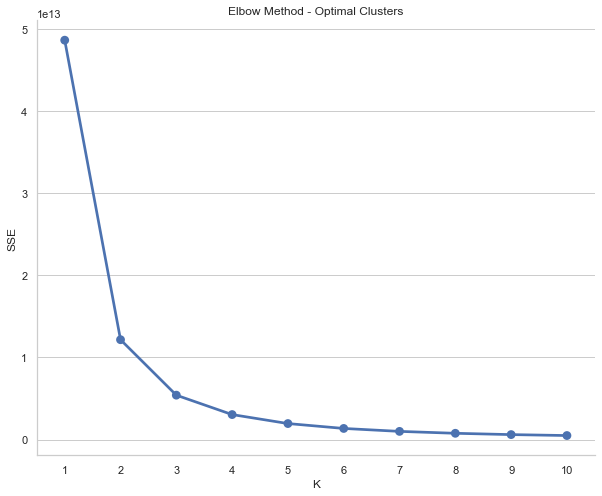

In [201]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.despine(left=False, bottom=False)

ax.set_title('Elbow Method - Optimal Clusters')

ax.set_xlabel('K')

ax.set_ylabel('SSE')

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

The elbow is showing sharp bends at 3 and 2 clusters. 

### Silhouette Scores 
#### A score closer to 1 indicated the data points are similar


for k in range(2,7):
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(rfm_normalized)

    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(k, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6267256151974118
For n_clusters=3, the silhouette score is 0.5901808304355237
For n_clusters=4, the silhouette score is 0.5719013108508932
For n_clusters=5, the silhouette score is 0.5609775451170603
For n_clusters=6, the silhouette score is 0.5537805912549567

Due to our business use, we'll keep using 3 clusters. However, I'd like to see if simplifying the clusters to the optimal 2 listed in the Shilouette analysis will give us better future modeling results. 

Kmeans = KMeans(n_clusters=2, random_state=42)

Kmeans.fit(rfm_normalized)

cluster_labels = Kmeans.labels_

#Create a dataframe with new cluster labels
rfm_kmeans2 = rfm.assign(RFM_Cluster=cluster_labels)

#Group data by cluster and calculate average RFM values and segment size per cluster
rfm_kmeans2_agg = rfm_kmeans2.groupby(['RFM_Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

print(rfm_kmeans2_agg)

         Recency Frequency Monetary       
               mean      mean     mean  count
RFM_Cluster

      0             105.1       1.7    286.4  41838

      1             697.7       3.0    446.5  41752

--------------------------------------------------------------------------------------------------------------------------------------------

## Target Varible 

### Classification precprocessing: High Risk Y or Low Risk N?

## Quick Cluster Analysis 

### Snake plot 

 ### Heatmap Relative Importance

#### Feature importance pearsons again

Keep the relevant features

Dummy Encoding Categorical

Create df for RFM manual segment

Create df for RFM Clusters

train/test split both

#### Update flat excel file with best clusters( Call them " Persona Cluster") integrated in to original features. 

file_name = 'Hotel_Customer_RFM.xlsx' 

hotel_customer_rfm.to_excel('Hotel_Customer_RFM.xlsx')




#### Baseline Dummy Classifier 

